In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import os
import copy

# Note: Model name used in paper and in code (here) are different.
# NNPhD -> SUPERLNN
# UAN -> BASE

In [2]:
class LNN(nn.Module):
    def __init__(self, d = 2, w=200):
        super(LNN, self).__init__()
        
        self.d = d
        self.l11 = nn.Linear(2*d,w)
        self.l12 = nn.Linear(2*d,w)
        self.l13 = nn.Linear(2*d,w)
        self.l3 = nn.Linear(2*w,1)
        
    def forward(self, x):
        self.x12 = self.l12(x)**2
        self.x13 = self.l13(x)
        self.x1 = torch.cat([self.x12,self.x13],dim=1)
        self.x3 = self.l3(self.x1)
        return self.x3
    
    def Lq(self, y, x):
        grads = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True, retain_graph=True)[0]
        return grads

    def Lqq(self, y, x):
        grads = self.Lq(y, x)
        ggs = []
        shp = grads.shape
        for i in range(shp[0]):
            gg = []
            for j in range(shp[1]):
                g = torch.autograd.grad(grads[i,j], x, torch.tensor(1.), create_graph=True, retain_graph=True)[0][i]
                gg.append(g)
            gg = torch.stack(gg)
            ggs.append(gg)
        return torch.stack(ggs)

    def qtt(self, Lqq_, Lq_, qt_):
        a = torch.tensor(1, dtype=torch.float)
        a = Variable(a, requires_grad=True)
        Lvv = Lqq_[:,self.d:2*self.d,self.d:2*self.d] + a
        Lxv = Lqq_[:,self.d:2*self.d,0:self.d]
        result = torch.matmul(torch.inverse(Lvv), torch.unsqueeze(Lq_[:,0:self.d],dim=2)-torch.matmul(Lxv,torch.unsqueeze(qt_,dim=2)))
        return result
    
    def predict(self, x):
        outputs = self.forward(x)
        Lqq_ = self.Lqq(outputs,x)
        Lq_ = self.Lq(outputs,x)
        qt_ = Variable(x[:,self.d:2*self.d],requires_grad=True)
        qtt_pred = self.qtt(Lqq_, Lq_, qt_)
        return qtt_pred

class BASE(nn.Module):
    def __init__(self, d = 2, w=200, mode="0"):
        super(BASE, self).__init__()
        self.mode = mode
        self.d = d
        if mode == "t":
            self.l1 = nn.Linear(1,w)
        elif mode == "qq":
            self.l1 = nn.Linear(2*d,w)
        elif mode == "qqt":
            self.l1 = nn.Linear(2*d+1,w)
            #self.l1 = nn.Linear(2*d+1,d)
        self.l2 = nn.Linear(w,w)
        self.l3 = nn.Linear(w,d)
        
    def forward(self, x):
        act = "relu"
        #f = F.relu
        f = nn.LeakyReLU(0.1)
        
        if self.mode == "t":
            self.x1 = f(self.l1(torch.unsqueeze(x[:,-1],dim=1)))
        elif self.mode == "qq":
            self.x1 = f(self.l1(x[:,:2*self.d]))
        elif self.mode == "qqt":
            self.x1 = f(self.l1(x))
        self.x2 = f(self.l2(self.x1))
        self.x3 = self.l3(self.x2)
        return self.x3

class SUPERLNN(nn.Module):
    def __init__(self, d = 2, w=200, mode="0"):
        super(SUPERLNN, self).__init__()
        self.lnn = LNN(d=d)
        self.d = d
        self.base = BASE(d=d, mode=mode)
        self.mode = mode
            
    def forward(self, x):
        self.x1 = self.lnn(x[:,:2*self.d])
        if self.mode == "0":
            return self.x1
        else:
            self.x2 = self.base(x)
            return self.x1 + self.x2
    



In [3]:
# data
n_train = 100
d = 1
x = torch.normal(0,1,size=(n_train,2*d+1))
x = Variable(x, requires_grad=True)
y = -x[:,0]-0.5*torch.sin(x[:,1])

In [4]:
#modes = ["qqt","qq","t","0"]
modes = ["qqt"]

batch_size = 32
log = 10
lrs = [1e-2,1e-3,1e-4,1e-5]

for j in range(len(modes)):
    np.random.seed(0)
    torch.manual_seed(0)
    loss_qtts = []
    mode = modes[j]
    print("***************mode={}***************".format(mode))
    superlnn = SUPERLNN(d=1, mode=mode)
    epochs = 1000
    if mode == "0":
        lambs = [0]
    else:
        lambs = [0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10,20,50,100]
        #lambs = [0]
    for i in range(len(lambs)):
        lamb = lambs[i]
        print("--------------lamb={}-------------".format(lamb))
        for epoch in range(epochs):
            if epoch % int(epochs/4) == 0:
                idd = int(np.ceil(4*epoch/epochs))
                optimizer = optim.Adam(superlnn.parameters(), lr = lrs[idd])
            superlnn.train()
            optimizer.zero_grad()
            if epoch < epochs-1:
                choices = np.random.choice(n_train, batch_size)
            else:
                choices = np.arange(n_train)
            inputs = torch.tensor(x[choices] ,dtype=torch.float, requires_grad=True)
            labels = torch.tensor(y[choices] ,dtype=torch.float, requires_grad=True)
            # LNN predict
            lnn_pred = superlnn.lnn.predict(inputs[:,:2*superlnn.d])[:,:,0]
            # Base predict
            if mode == "0":
                loss = loss_qtt
            else:
                base_pred = superlnn.base(inputs)
                qtt_pred = lnn_pred + base_pred
                if d==1:
                    loss_qtt = torch.norm(qtt_pred[:,0]-labels, p=2)/torch.sqrt(torch.tensor(choices.shape[0],dtype=torch.float))
                else:
                    loss_qtt = torch.norm(qtt_pred-labels, p=2)/torch.sqrt(torch.tensor(choices.shape[0],dtype=torch.float))
                loss_baseact = torch.norm(base_pred, p=2)/torch.sqrt(torch.tensor(choices.shape[0],dtype=torch.float))
                loss = loss_qtt + lamb * loss_baseact
            loss.backward(retain_graph=True)
            optimizer.step()
            if epoch%log == 0:
                if mode == "0":
                    print('Epoch:  %d | Loss_qtt: %.4f' %(epoch, loss_qtt))
                else:
                    print('Epoch:  %d | Loss_qtt: %.4f | Loss_base: %.4f' %(epoch, loss_qtt, loss_baseact))
        loss_qtts.append(loss_qtt.detach().numpy())
        torch.save(superlnn.state_dict(), "./models/resonance/mode_%s_lamb_%.2f_p2"%(mode, lamb))
    loss_qtts = np.array(loss_qtts)
    np.savetxt('./results/resonance/mode_%s_p2'%mode, np.array([np.array(lambs), loss_qtts]))
    




***************mode=qqt***************
--------------lamb=0.01-------------


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  0 | Loss_qtt: 5.2287 | Loss_base: 0.1006
Epoch:  10 | Loss_qtt: 40.1132 | Loss_base: 99.9153
Epoch:  20 | Loss_qtt: 18.9513 | Loss_base: 19.9104
Epoch:  30 | Loss_qtt: 1.4307 | Loss_base: 16.5687
Epoch:  40 | Loss_qtt: 2.7059 | Loss_base: 19.5258
Epoch:  50 | Loss_qtt: 1.4116 | Loss_base: 20.3386
Epoch:  60 | Loss_qtt: 0.5313 | Loss_base: 18.6939
Epoch:  70 | Loss_qtt: 0.1297 | Loss_base: 27.9739
Epoch:  80 | Loss_qtt: 0.0757 | Loss_base: 22.0587
Epoch:  90 | Loss_qtt: 0.0914 | Loss_base: 24.1331
Epoch:  100 | Loss_qtt: 0.0459 | Loss_base: 20.7166
Epoch:  110 | Loss_qtt: 0.0728 | Loss_base: 21.3392
Epoch:  120 | Loss_qtt: 0.0408 | Loss_base: 19.3590
Epoch:  130 | Loss_qtt: 0.0287 | Loss_base: 17.3282
Epoch:  140 | Loss_qtt: 0.0289 | Loss_base: 19.8470
Epoch:  150 | Loss_qtt: 0.0294 | Loss_base: 31.3845
Epoch:  160 | Loss_qtt: 0.0282 | Loss_base: 28.9649
Epoch:  170 | Loss_qtt: 0.0285 | Loss_base: 25.3296
Epoch:  180 | Loss_qtt: 0.0139 | Loss_base: 15.0031
Epoch:  190 | Loss_qtt

Epoch:  180 | Loss_qtt: 0.0053 | Loss_base: 0.6576
Epoch:  190 | Loss_qtt: 0.0091 | Loss_base: 0.5486
Epoch:  200 | Loss_qtt: 0.0101 | Loss_base: 0.6126
Epoch:  210 | Loss_qtt: 0.0102 | Loss_base: 0.5255
Epoch:  220 | Loss_qtt: 0.0165 | Loss_base: 0.4900
Epoch:  230 | Loss_qtt: 0.0081 | Loss_base: 0.6331
Epoch:  240 | Loss_qtt: 0.0262 | Loss_base: 0.5475
Epoch:  250 | Loss_qtt: 0.0310 | Loss_base: 0.5824
Epoch:  260 | Loss_qtt: 0.0068 | Loss_base: 0.6513
Epoch:  270 | Loss_qtt: 0.0086 | Loss_base: 0.5768
Epoch:  280 | Loss_qtt: 0.0046 | Loss_base: 0.5396
Epoch:  290 | Loss_qtt: 0.0052 | Loss_base: 0.5314
Epoch:  300 | Loss_qtt: 0.0083 | Loss_base: 0.7489
Epoch:  310 | Loss_qtt: 0.0053 | Loss_base: 0.5091
Epoch:  320 | Loss_qtt: 0.0053 | Loss_base: 0.5646
Epoch:  330 | Loss_qtt: 0.0074 | Loss_base: 0.6198
Epoch:  340 | Loss_qtt: 0.0082 | Loss_base: 0.7141
Epoch:  350 | Loss_qtt: 0.0056 | Loss_base: 0.6606
Epoch:  360 | Loss_qtt: 0.0072 | Loss_base: 0.5236
Epoch:  370 | Loss_qtt: 0.0059 

Epoch:  370 | Loss_qtt: 0.1420 | Loss_base: 0.1391
Epoch:  380 | Loss_qtt: 0.1765 | Loss_base: 0.1646
Epoch:  390 | Loss_qtt: 0.1440 | Loss_base: 0.1401
Epoch:  400 | Loss_qtt: 0.1341 | Loss_base: 0.1364
Epoch:  410 | Loss_qtt: 0.1431 | Loss_base: 0.1396
Epoch:  420 | Loss_qtt: 0.1441 | Loss_base: 0.1433
Epoch:  430 | Loss_qtt: 0.1382 | Loss_base: 0.1470
Epoch:  440 | Loss_qtt: 0.1616 | Loss_base: 0.1618
Epoch:  450 | Loss_qtt: 0.1479 | Loss_base: 0.1546
Epoch:  460 | Loss_qtt: 0.1295 | Loss_base: 0.1270
Epoch:  470 | Loss_qtt: 0.1710 | Loss_base: 0.1656
Epoch:  480 | Loss_qtt: 0.1855 | Loss_base: 0.1719
Epoch:  490 | Loss_qtt: 0.1879 | Loss_base: 0.1854
Epoch:  500 | Loss_qtt: 0.1663 | Loss_base: 0.1677
Epoch:  510 | Loss_qtt: 0.1539 | Loss_base: 0.1558
Epoch:  520 | Loss_qtt: 0.1598 | Loss_base: 0.1583
Epoch:  530 | Loss_qtt: 0.1945 | Loss_base: 0.1944
Epoch:  540 | Loss_qtt: 0.1625 | Loss_base: 0.1650
Epoch:  550 | Loss_qtt: 0.1304 | Loss_base: 0.1287
Epoch:  560 | Loss_qtt: 0.1973 

Epoch:  560 | Loss_qtt: 0.5217 | Loss_base: 0.0052
Epoch:  570 | Loss_qtt: 0.5823 | Loss_base: 0.0058
Epoch:  580 | Loss_qtt: 0.5373 | Loss_base: 0.0053
Epoch:  590 | Loss_qtt: 0.5779 | Loss_base: 0.0058
Epoch:  600 | Loss_qtt: 0.7110 | Loss_base: 0.0070
Epoch:  610 | Loss_qtt: 0.7252 | Loss_base: 0.0073
Epoch:  620 | Loss_qtt: 0.4390 | Loss_base: 0.0044
Epoch:  630 | Loss_qtt: 0.5782 | Loss_base: 0.0058
Epoch:  640 | Loss_qtt: 0.6073 | Loss_base: 0.0060
Epoch:  650 | Loss_qtt: 0.5968 | Loss_base: 0.0059
Epoch:  660 | Loss_qtt: 0.6066 | Loss_base: 0.0061
Epoch:  670 | Loss_qtt: 0.4851 | Loss_base: 0.0049
Epoch:  680 | Loss_qtt: 0.5653 | Loss_base: 0.0057
Epoch:  690 | Loss_qtt: 0.6541 | Loss_base: 0.0065
Epoch:  700 | Loss_qtt: 0.6664 | Loss_base: 0.0067
Epoch:  710 | Loss_qtt: 0.6075 | Loss_base: 0.0061
Epoch:  720 | Loss_qtt: 0.4939 | Loss_base: 0.0049
Epoch:  730 | Loss_qtt: 0.5610 | Loss_base: 0.0056
Epoch:  740 | Loss_qtt: 0.6069 | Loss_base: 0.0060
Epoch:  750 | Loss_qtt: 0.5038 

Epoch:  750 | Loss_qtt: 0.6596 | Loss_base: 0.0001
Epoch:  760 | Loss_qtt: 0.5186 | Loss_base: 0.0001
Epoch:  770 | Loss_qtt: 0.6276 | Loss_base: 0.0001
Epoch:  780 | Loss_qtt: 0.5763 | Loss_base: 0.0001
Epoch:  790 | Loss_qtt: 0.5156 | Loss_base: 0.0001
Epoch:  800 | Loss_qtt: 0.5998 | Loss_base: 0.0001
Epoch:  810 | Loss_qtt: 0.5752 | Loss_base: 0.0001
Epoch:  820 | Loss_qtt: 0.7689 | Loss_base: 0.0001
Epoch:  830 | Loss_qtt: 0.6356 | Loss_base: 0.0001
Epoch:  840 | Loss_qtt: 0.5825 | Loss_base: 0.0001
Epoch:  850 | Loss_qtt: 0.4984 | Loss_base: 0.0000
Epoch:  860 | Loss_qtt: 0.7108 | Loss_base: 0.0001
Epoch:  870 | Loss_qtt: 0.7202 | Loss_base: 0.0001
Epoch:  880 | Loss_qtt: 0.7681 | Loss_base: 0.0001
Epoch:  890 | Loss_qtt: 0.6733 | Loss_base: 0.0001
Epoch:  900 | Loss_qtt: 0.6820 | Loss_base: 0.0001
Epoch:  910 | Loss_qtt: 0.5937 | Loss_base: 0.0001
Epoch:  920 | Loss_qtt: 0.6047 | Loss_base: 0.0001
Epoch:  930 | Loss_qtt: 0.9364 | Loss_base: 0.0001
Epoch:  940 | Loss_qtt: 0.7344 

In [6]:
import numpy as np
import matplotlib.pyplot as plt

data = "resonance"
modes = ["qqt","qq","t","0"]
x = []
lamb = np.loadtxt('./results/{}/mode_qqt_p2'.format(data))[0]
qqt = np.loadtxt('./results/{}/mode_qqt_p2'.format(data))[1]
#qq = np.loadtxt('./results/{}/mode_qq'.format(data))[1]
#t = np.loadtxt('./results/{}/mode_t'.format(data))[1]
#lnn = np.loadtxt('./results/{}/mode_0'.format(data))[1]

Text(0, 0.5, '$L_2$')

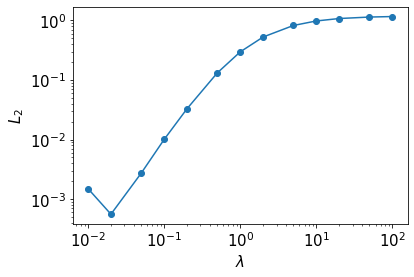

In [8]:
plt.plot(lamb, qqt, marker="o")
#plt.plot(lamb, qq, marker="o")
#plt.plot(lamb, t, marker="o")
#plt.plot(lamb, [lnn]*13)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r"$\lambda$",fontsize=15)
plt.ylabel(r"$L_2$",fontsize=15)